Exception ignored in: <function Cell.__del__ at 0x7f1fe4021e60>
Traceback (most recent call last):
  File "/home/user/.local/lib/python3.7/site-packages/mindspore/nn/cell.py", line 325, in __del__
    cells_compile_cache.pop(id(self))
KeyError: (139774918629904,)
--------------------------
training...

training_time： 99.79751324653625 s


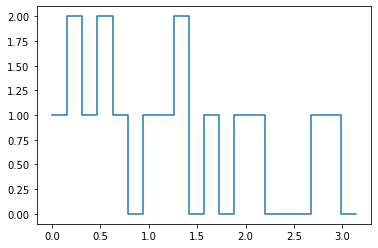

testing_fid： 0.9785886233180165


In [2]:
import copy
import random
from time import *
import numpy as np
from mindquantum import *
from collections import deque
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mindspore import dataset as ds
from mindspore.common.initializer import Normal
from mindspore import Model, Tensor, nn, set_seed

set_seed(1)  # 设置宏观随机数种子

sx = X.matrix()
sz = Z.matrix()
dt = np.pi / 20
action_space = [0, 1, 0, 0.5, 1]

class env():
    def __init__(self,
                 action_space=[0, 1, 2],
                 dt=0.1):
        self.action_space = action_space
        self.n_actions = len(self.action_space)
        self.n_features = 4
        self.dt = dt
        self.nstep = 0
        self.state = np.array([1, 0, 0, 0])
        # self.state = np.matrix([[0.+0.j, 0.+0.j], [0.+0.j, 1.+0.j]])

    def reset(self):
        self.state = np.array([1, 0, 0, 0]).astype(np.float32)
        # self.state = np.matrix([[0.+0.j, 0.+0.j], [0.+0.j, 1.+0.j]])
        # state = np.array([init_psi[0].real, init_psi[1].real, init_psi[0].imag, init_psi[1].imag])
        self.nstep = 0
        return self.state

    def step(self, action):
        psi = np.array(
            [self.state[0:int(len(self.state) / 2)] + self.state[int(len(self.state) / 2):int(len(self.state))] * 1j])
        psi = psi * psi.transpose()
        psi = psi.T
        psi = np.mat(psi)

        J = 4  # control field strength
        sx = np.mat([[0, 1], [1, 0]]).astype(np.float32)
        sz = np.mat([[1, 0], [0, -1]]).astype(np.float32)

        U = np.matrix(np.identity(2))

        H = J * float(action) / (self.n_actions - 1) * sz + 1 * sx
        U = expm(-1j * H * self.dt)

        psi = U * psi  # final state

        # state_ = psi
        # target = np.mat([[0], [1]], dtype=complex)
        target = np.matrix([[1, 0], [0, 0]]).astype(np.float32)

        err = 1.0 - np.square(np.abs(psi.H * target)).item(0).real
        fid = 1.0 - err

        rwd = 10 * (err < 0.5) + 100 * (err < 0.1) + 5000 * (err < 10e-3)

        done = ((err < 10e-3) or self.nstep >= np.pi / self.dt)
        self.nstep += 1
        psi = np.array(psi)
        psi_T = psi.T
        self.state = np.array(psi_T.real.tolist()[0] + psi_T.imag.tolist()[0])
        # self.state = np.array([psi_T[0][0].real, psi_T[1][0].real, psi_T[0][0].imag, psi_T[1][0].imag])

        return self.state, rwd, done, fid


class LinearNet(nn.Cell):
    def __init__(self):
        super(LinearNet, self).__init__()  # 网络： 两个隐藏层，分别有 32/32 个神经元；输出层 4 个神经元。
        self.fc1 = nn.Dense(4, 64, Normal(0.02), Normal(0.02), True, "relu")
        self.fc2 = nn.Dense(64, 64, Normal(0.02), Normal(0.02), True, "relu")
        self.fc3 = nn.Dense(64, 4, Normal(0.02), Normal(0.02), True, "relu")

    def construct(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q_values = self.fc3(x)
        return q_values

net = LinearNet()

class Agent(nn.Cell):
    def __init__(self,
                 n_actions=4,
                 n_features=4,
                 learning_rate=0.01,
                 reward_decay=0.9,
                 e_greedy=0.9,
                 replace_target_iter=300,
                 memory_size=500,
                 batch_size=32,
                 e_greedy_increment=None):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if self.epsilon_increment is not None else self.epsilon_max
        self.replace_target_iter = replace_target_iter
        self.batch_size = batch_size
        self.learn_step_counter = 0
        self.memory_size = memory_size
        self.memory = deque(maxlen=self.memory_size)
        # self.memory = np.zeros((self.memory_size, n_features * 2 + 2))
        self.memory_counter = 0
        self.main_net = Model(net, nn.loss.MSELoss(),
                              nn.RMSProp(params=net.trainable_params(), learning_rate=self.lr))  # 主网络
        self.target_net = self.main_net  # 目标网络

    def store_transition(self, s, a, r, s_):
        self.memory.append([s, a, r, s_])
        self.memory_counter += 1

    def choose_action(self, state, tanxin):
        if np.random.uniform() < self.epsilon:
            action = np.argmax(self.main_net.predict(Tensor([state])))
        else:
            # action = np.random.randint(0, self.n_actions)
            # action = random.uniform(-1,1)
            action = random.choice([0, 1, 2])
        return action

    def get_samples(self, s_batch, Q):
        for i in range(len(s_batch)):
            yield s_batch[i], Q[i]

    def get_train_data(self, s_batch, Q):
        train_data = ds.GeneratorDataset(list(self.get_samples(s_batch, Q)), column_names=['state', 'Q'])
        train_data = train_data.batch(self.batch_size)
        return train_data

    def learn(self):
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.target_net = self.main_net
        if self.memory_counter < self.batch_size:
            return
        batch_memory = random.sample(self.memory, self.batch_size)
        s_batch = np.array([replay[0] for replay in batch_memory]).astype(np.float32)
        Q = self.main_net.predict(Tensor(s_batch))
        next_s_batch = np.array([replay[3] for replay in batch_memory]).astype(np.float32)
        Q_next = self.target_net.predict(Tensor(next_s_batch))

        # 更新Q值
        for i, replay in enumerate(batch_memory):
            _, a, reward, _ = replay
            Q[int(i)][int(a)] = reward + self.gamma * max(Q_next[i])
        train_data = self.get_train_data(s_batch, Q)
        self.main_net.train(1, train_data, dataset_sink_mode=False)
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1


# 训练过程
def training(ep_max):
    training_set = np.array([0, 0, 0, 1])
    validation_set = np.array([0, 0, 0, 1])

    print('--------------------------')
    print('training...')
    for i in range(ep_max):
        fid_max = 0
        observation = env.reset()
        nstep = 0

        while True:
            action = agent.choose_action(observation, 0.5)
            observation_, reward, done, fid = env.step(action)
            nstep += 1
            fid_max = max(fid_max, fid)
            agent.store_transition(observation, action, reward, observation_)
            agent.learn()
            observation = observation_
            if done:
                break

        if i % 1 == 0:  # 每 x 个回合用验证集验证一下效果
            validation_fid_list = []
            validation_reward_tot_list = []
            for j in range(10):
                validation_fid_max = 0
                validation_reward_tot = 0

                observation = env.reset()
                nstep = 0

                while True:
                    action = agent.choose_action(observation, 0.5)

                    observation_, reward, done, fid = env.step(action)
                    nstep += 1
                    validation_fid_max = max(validation_fid_max, fid)
                    validation_reward_tot = validation_reward_tot + reward * (agent.gamma ** nstep)
                    observation = observation_
                    if done:
                        break
                validation_fid_list.append(validation_fid_max)
                validation_reward_tot_list.append(validation_reward_tot)
            # validation_reward_history.append(np.mean(validation_reward_tot_list))
            # validation_fid_history.append(np.mean(validation_fid_list))

def testing():
    ep_max = 50

    for i in range(ep_max):

        fid_max = 0
        observation = env.reset()
        nstep = 0
        num_actions = []
        num_actions_max =[]

        while True:
            action = agent.choose_action(observation, 0.5)
            num_actions.append(action)
            # print(num_actions)
            observation_, reward, done, fid = env.step(action)
            nstep += 1
            if fid > fid_max:
                num_actions_max = num_actions
            fid_max = max(fid_max, fid)

            # sphere = Bloch3d()
            # sphere.add_states(states)
            # sphere.show()
            if done:
                break
    steps = [i * dt for i in range(len(num_actions_max))]
    plt.clf()
    plt.step(steps, num_actions_max)
    # plt.plot(num_actions, 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label='action')
    plt.show()

    return fid_max


if __name__ == "__main__":
    env = env(action_space=list(range(2)), dt=np.pi / 20
              )

    agent = Agent(env.n_actions, env.n_features,
                  learning_rate=0.01,
                  reward_decay=0.9,
                  e_greedy=0.99,
                  replace_target_iter=200,
                  memory_size=2000,
                  e_greedy_increment=0.001)

    begin_training = time()
    training(ep_max=30)
    end_training = time()
    training_time = end_training - begin_training
    print('\ntraining_time：', training_time, "s")
    # 测试
    testing_fid = testing()
    print('testing_fid：', testing_fid)

